# Selecting and Training a Machine Learning Model

**Goals:** Prepare the data for machine learning algorithms, train and 
evaluate machine learning models, tune hyperparameters and select the 
best model.

**Summary:** The primary purpose of this notebook is to select a machine
learning model whose goal is to classify a given loan instance as either 
'Fully Paid' or 'Charged Off'. It is important to first choose a metric 
to evaluate machine learning models. Our dataset is imbalanced: 
approximately 80% of the data belongs to the negative class ('Fully Paid'), 
and 20% belongs to the positive class ('Charged Off'). Accuracy is an 
inappropriate metric because of this imbalance. 

The high-level objective is to limit the number of false negatives: A 
potential investor would rather miss an investment opportunity than fund 
a risky loan. Two metrics are used for evaluation: Precision-Recall Area 
Under the Curve (PR AUC) and Receiver Operating Characteristic Area Under 
the Curve (ROC AUC). The PR curve gives a visualization of the trade-off 
between the True Positive Rate (TPR, also known as Recall) and the 
Positive Predictive Value (PPV, also known as Precision) for different 
decision value or probability thresholds. On the other hand, the ROC curve 
gives a visualization of the trade-off between the True Positive Rate and 
False Positive Rate (FPR) for different decision value or probability 
thresholds. 

We summarize below our findings and the actions taken to achieve the stated 
goals.

1) **Prepare the data for machine learning algorithms:** We create a 
pipeline which performs the tasks of imputation, scaling (if necessary), 
and encoding categorical features. We include in the pipeline custom 
transformers which do some feature engineering.


2) **Train and evaluate machine learning models:** We consider four models:
Logistic Regression, Random Forest, Linear Discriminant Analysis, and 
K-Nearest Neighbors. To estimate overfitting, we evaluate each of the four 
models on the training dataset, first without cross-validation, and second 
with cross-validation. The latter allows us to rank our models, and we 
select the top models for hyperparameter tuning, with an aim to reduce 
overfitting. The two metrics used give identical rankings.


3) **Tune hyperparameters and the select best model:** We perform 
hyperparameter tuning using a grid search with cross-validation 
on the training dataset. We choose the best performing model as our final 
model, and evaluate it on the test set.

In [1]:
# Load required packages and modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from math import ceil
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import ConvergenceWarning
from joblib import Parallel, delayed
from warnings import simplefilter
from time import sleep

# Suppress convergence warnings.
simplefilter('ignore', category=ConvergenceWarning)

# Set the backend of matplotlib to 'inline'.
%matplotlib inline

# Create plots using seaborn's default aesthetic arguments. 
sns.set()

# Make this notebook's output identical across runs.
np.random.seed(1)

## 1. Prepare the Data for Machine Learning Algorithms

In [2]:
# Read the training data into a pandas dataframe.
loan_data_train = pd.read_hdf('data/loan_data_train_and_test.hd5', 
                              key='train')

In [3]:
n_rows, n_cols = loan_data_train.shape
print(f'Size of the training dataset: {n_rows} rows and {n_cols} columns')

Size of the training dataset: 1076244 rows and 28 columns


Let’s separate the predictor features and the target feature (labels):

In [4]:
loan_data_train_labels = loan_data_train['loan_status'].copy()
loan_data_train.drop(columns=['loan_status'], inplace=True)

Let's remind ourselves of the predictor features:

In [5]:
print(sorted(loan_data_train.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'term', 'total_acc', 'verification_status', 'zip_code']


Let's split the features into numerical features and categorical features:

In [6]:
# Numerical features
num_features = ['annual_inc', 'dti', 'fico_range_high', 'fico_range_low', 
                'installment', 'int_rate', 'loan_amnt', 'mort_acc', 
                'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 
                'revol_util', 'tax_liens', 'total_acc']

# Categorical features
cat_features = ['addr_state', 'application_type', 'earliest_cr_line', 
                'emp_length', 'home_ownership', 'initial_list_status', 
                'issue_d', 'purpose', 'sub_grade', 'term', 
                'verification_status', 'zip_code']

Let's split the categorical features into ordinal features and nominal
features:

In [7]:
# Ordinal features
ord_features = ['sub_grade']

# Nominal features (1)
nom_features_1 = ['addr_state', 'application_type', 'emp_length',
                  'home_ownership', 'initial_list_status', 'purpose', 'term', 
                  'verification_status']

# Nominal features (2). These nominal features need to be handled differently 
# from the nominal features appearing above.
nom_features_2 = ['earliest_cr_line', 'issue_d', 'zip_code']

In the notebook *Exploring and Cleaning the Data* we identified the 
unique categories for the feature **sub_grade**. Let's collect these 
categories into a list:

In [8]:
# Categories for the feature 'sub_grade'.
sub_grade_cats = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 
                  'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 
                  'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 
                  'G1', 'G2', 'G3', 'G4', 'G5']

In the two cells below, we create custom transformers for numerical and
nominal features, respectively. By adding TransformerMixin as a base class,
we get the fit_transform() method for free. By adding BaseEstimator as a base 
class, we get the methods get_params() and set_params() which
will be useful for automatic hyperparameter tuning. 

Each of the two custom transformers below have one hyperparameter each. 
Having these hyperparameters available allows us, if we so choose, to 
automatically test (during a grid search) whether transforming a feature or
adding a new feature helps the machine learning algorithm or not.

The first custom transformer applies a log transform to certain features, and
adds the average of the features **fico_range_low** and **fico_range_high** 
as a new feature. The second custom transformer adds the approximate age of 
the oldest credit account and the zip code income as new features.

In [9]:
class NumericalFeatureModifier(BaseEstimator, TransformerMixin):
    """Add a new feature, drop some old features, and apply log transform to 
    certain features, as described in the transform method.
    
    Parameters
    ----------
    apply_log : boolean, optional, default True
        If True, apply log transform to the features 'annual_inc', 'dti', 
        and 'revol_bal'.
    
    num_features: list
                  Names of mumerical features.
    """
    
    def __init__(self, num_features, apply_log=True):        
        self.num_features = num_features
        self.apply_log = apply_log
        # Get column indices.
        self.annual_inc_idx = num_features.index('annual_inc')
        self.dti_idx = num_features.index('dti')
        self.fico_range_high_idx = num_features.index('fico_range_high')
        self.fico_range_low_idx = num_features.index('fico_range_low')
        self.revol_bal_idx = num_features.index('revol_bal')
        
    def fit(self, X, y=None):
        """Do nothing.
        
        Parameters
        ----------
        X : numpy array, shape [n_rows, n_cols]
            The data to be transformed.
        
        y : None
            Ignored.
            
        Returns
        -------
        self : object
               Transformer instance.
        """        
        return self
    
    def transform(self, X):
        """Add the average of the features 'fico_range_low' and 
        'fico_range_high' as a new feature. Drop the features fico_range_low 
        and fico_range_high. Apply log transform to the features 
        annual_inc, dti, and revol_bal.

        Parameters
        ----------
        X :  numpy array, shape [n_rows, n_cols]
             The data to be transformed.

        Returns
        -------
        X_tr: numpy array, [n_rows, n_cols]
              The transformed array.
        """
        import numpy as np
        fico_score_avg = (0.5*X[:, self.fico_range_low_idx] 
                         + 0.5*X[:, self.fico_range_high_idx])      
        if self.apply_log:
            # Apply log transform to the features 'annual_inc', 'dti', and 
            # 'revol_bal'.
            log_annual_inc = np.log10(X[:, self.annual_inc_idx] + 1)
            log_dti = np.log10(X[:, self.dti_idx] + 1)
            log_revol_bal = np.log10(X[:, self.revol_bal_idx] + 1)
            # Drop the features 'annual_inc', 'dti', 'revol_bal', 
            # 'fico_range_low', and 'fico_range_high'.
            X = np.delete(X, 
                          [self.fico_range_low_idx, self.fico_range_high_idx,
                           self.annual_inc_idx, self.dti_idx, 
                           self.revol_bal_idx], 
                          1)
            return np.c_[X, fico_score_avg, log_annual_inc, log_dti, 
                         log_revol_bal]
        else:
            X = np.delete(X, [self.fico_range_low_idx, 
                              self.fico_range_high_idx], 1)
            return np.c_[X, fico_score_avg]

In [10]:
# Read the zip code data into a pandas dataframe.
zip3_code_data = pd.read_hdf('data/loan_data_train_and_test.hd5', 
                             key='zip_code')

In [11]:
class NominalFeatureModifier(BaseEstimator, TransformerMixin):
    """Approximate the age of oldest credit acccount, and add it as a new
    feature. Add the zip code income as a new feature.
    
    Parameters
    ----------
    add_zip_code_inc : boolean, optional, default True
        If True, add the 'zip code income' feature.  
        
    nom_features_2: list
                    Names of some nominal features.
                    
    zip3_code_data: pandas dataframe
                    Median household income by zip code.
    """
    
    def __init__(self, nom_features_2, zip3_code_data, add_zip_code_inc=True):
        self.nom_features_2 = nom_features_2
        self.zip3_code_data = zip3_code_data
        self.add_zip_code_inc = add_zip_code_inc 
        # Get column indices.
        self.earliest_cr_line_idx = nom_features_2.index('earliest_cr_line')
        self.issue_d_idx = nom_features_2.index('issue_d')
        self.zip_code_idx = nom_features_2.index('zip_code')
        
    def fit(self, X, y=None):
        """Do nothing.
        
        Parameters
        ----------
        X : numpy array, shape [n_rows, n_cols]
            The data to be transformed.
        
        y : None
            Ignored.
            
        Returns
        -------
        self : object
               Transformer instance.
        """        
        return self
    
    def transform(self, X):
        """Add the approximate age of the oldest credit line and the zip code
        income as new features.

        Parameters
        ----------
        X :  numpy array, shape [n_rows, n_cols]
             The data to be transformed.

        Returns
        -------
        X_tr: numpy array, [n_rows, n_cols]
              The transformed array.
        """
        import numpy as np
        import pandas as pd
        start_date = pd.to_datetime(X[:, self.earliest_cr_line_idx], 
                                    format='%b-%Y') 
        end_date = pd.to_datetime(X[:, self.issue_d_idx], format='%b-%Y')
        # Compute the approximate age of the oldest credit line.                        
        cr_line_age = ((end_date - start_date).days).values
        if self.add_zip_code_inc:            
            zip_code_inc = self.zip3_code_data[X[:, self.zip_code_idx]].values            
            return np.c_[cr_line_age, zip_code_inc]
        else:
            # The transformer 'ColumnTransformer' expects a column vector, 
            # not a row vector, so convert the row vector 'cr_line_age' to a 
            # column vector.                  
            return cr_line_age.reshape(-1,1)

Next, we first create preprocessing pipelines for numerical and categorical 
features, and then create two full preprocessor pipelines,
one for linear models and the other for nonlinear models. The nonlinear
preprocessor does not include any feature scaling, while the linear one does. 
Nonlinear models such as Random Forest do not need feature scaling, and as 
such they will use the nonlinear preprocesssor.

In [12]:
# Numerical preprocessor to use for linear models.
num_preprocessor_lin = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('modifier', NumericalFeatureModifier(num_features)),
    ('scaler', StandardScaler())
])

# Numerical preprocessor to use for nonlinear models.
num_preprocessor_nlin = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('modifier', NumericalFeatureModifier(num_features, apply_log=False))
])

# Ordinal preprocessor to use for linear models.
ord_preprocessor_lin = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=[sub_grade_cats])),
    ('scaler', StandardScaler())
])

# Ordinal preprocessor to use for nonlinear models.
ord_preprocessor_nlin = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=[sub_grade_cats]))
])

# Nominal preprocessor #1 to use for both linear and nonlinear models.
nom_preprocessor_1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('nom_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

nom_preprocessor_1_lin = nom_preprocessor_1
nom_preprocessor_1_nlin = nom_preprocessor_1

# Nominal preprocessor #2 to use for linear models.
nom_preprocessor_2_lin = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('modifier', NominalFeatureModifier(nom_features_2, zip3_code_data)),
    ('scaler', StandardScaler())
])

# Nominal preprocessor #2 to use for nonlinear models.
nom_preprocessor_2_nlin = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('modifier', NominalFeatureModifier(nom_features_2, zip3_code_data))
])

# Preprocessor to use for linear models.
preprocessor_lin = ColumnTransformer([
    ('num_preproc', num_preprocessor_lin, num_features),
    ('ord_preproc', ord_preprocessor_lin, ord_features),
    ('nom_preproc_1', nom_preprocessor_1_lin, nom_features_1),
    ('nom_preproc_2', nom_preprocessor_2_lin, nom_features_2)
])  

# Preprocessor to use for nonlinear models.
preprocessor_nlin = ColumnTransformer([
    ('num_preproc', num_preprocessor_nlin, num_features),
    ('ord_preproc', ord_preprocessor_nlin, ord_features),
    ('nom_preproc_1', nom_preprocessor_1_nlin, nom_features_1),
    ('nom_preproc_2', nom_preprocessor_2_nlin, nom_features_2)
]) 

# Append classifier to the preprocessing pipeline, to get a full prediction 
# pipeline for each model.

logreg_clf = Pipeline([
    ('preproc', preprocessor_lin),
    ('classifier', LogisticRegression())
])

rnd_forest_clf = Pipeline([
    ('preproc', preprocessor_nlin),
    ('classifier', RandomForestClassifier())
])

lda_clf = Pipeline([
    ('preproc', preprocessor_lin),
    ('classifier', LinearDiscriminantAnalysis())    
])

# Reduce the dimensionality of the data using PCA, to alleviate the effects 
# of the curse of dimensionality.
knn_clf = Pipeline([
    ('preproc', preprocessor_lin),
    ('pca', PCA(7)),
    ('classifier', KNeighborsClassifier())
])

# Create lists of prediction pipelines and their names for later use.
clfs = [logreg_clf, rnd_forest_clf, lda_clf, knn_clf]
clf_names = ['Logistic Regression', 'Random Forest',
             'Linear Discriminant Analysis', 'K-Nearest Neighbors']

## 2. Train and Evaluate Machine Learning Models

In the two cells below, we define functions that plot Precision-Recall curves 
and Receiver Operating Characteristic (ROC) curves, respectively.

In [13]:
def plot_pr_curves(y_true, y_scores, pos_label=None, threshold=None, 
                   descr=None):
    """Plot Precision-Recall curves for given true binary labels and 
    predicted decision values or probabilities of the positive class.
        
    Parameters
    ----------
    y_true : array-like, shape [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, 
        then pos_label should be explicitly given.
        
    y_scores : dictionary, with values array-like of shape [n_samples]
        Target scores. Predicted decision values (as returned by 
        decision_function on some classifiers) or probabilities of the 
        positive class.
             
    pos_label : int or str, default None
        The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be 
        raised.
    
    threshold : float, default None
                Threshold to mark on the curve.
                
    descr : str, default None
            Description of the data.
    """ 
    n_cols = 4
    n_rows = ceil(len(y_scores)/n_cols)
    aspect = 1
    fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
    title = 'Precision-Recall Curve'
    if descr is not None: title = title + ' for ' + descr
    fig.suptitle(title, fontsize=16)
 
    for counter, key in enumerate(y_scores, 1):
        precision, recall, thresholds = precision_recall_curve(
            y_true, y_scores[key], pos_label=pos_label)
        ax = fig.add_subplot(n_rows, n_cols, counter)
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.plot(recall, precision)
        x = [0, 1]
        if pos_label is None: pos_label = 1
        y = [((y_true == pos_label).sum())/len(y_true)]*2
        ax.plot(x, y, linestyle='--', linewidth=1, color='red', 
                alpha=0.5, label='Baseline')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')    
        ax.set_title(key)
        
        if threshold is not None:
            # Find threshold closest to given threshold
            close_threshold = np.argmin(np.abs(thresholds - threshold))
            ax.plot(recall[close_threshold], precision[close_threshold], 
                    linestyle='none', marker='o', markersize=6, 
                    markeredgewidth=2, fillstyle='none', color='black', 
                    label=f'Threshold {threshold}')        
            
        ax.legend(loc='lower center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.75, wspace=0.3, hspace=0.4)       

In [14]:
def plot_roc_curves(y_true, y_scores, pos_label=None, threshold=None, 
                    descr=None):
    """Plot ROC curves for given true binary labels and predicted decision 
    values or probabilities of the positive class.
        
    Parameters
    ----------
    y_true : array-like, shape [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, 
        then pos_label should be explicitly given.
        
    y_scores : dictionary, with values array-like of shape [n_samples]
        Target scores. Predicted decision values (as returned by 
        decision_function on some classifiers) or probabilities of the 
        positive class.
             
    pos_label : int or str, default None
        The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be 
        raised.
    
    threshold : float, default None
                Threshold to mark on the curve. 
                
    descr : str, default None
            Description of the data.
    """        
    n_cols = 4
    n_rows = ceil(len(y_scores)/n_cols)
    aspect = 1
    fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
    title = 'ROC Curve'
    if descr is not None: title = title + ' for ' + descr
    fig.suptitle(title, fontsize=16)
    
    for counter, key in enumerate(y_scores, 1):
        fpr, recall, thresholds = roc_curve(
            y_true, y_scores[key], pos_label=pos_label)
        ax = fig.add_subplot(n_rows, n_cols, counter)
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.plot(fpr, recall)
        x = [0, 1]
        ax.plot(x, x, linestyle='--', linewidth=1, color='red', 
                alpha=0.5, label='Baseline')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('Recall (True Positive Rate)')    
        ax.set_title(key)
        
        if threshold is not None:
            # Find threshold closest to given threshold       
            close_threshold = np.argmin(np.abs(thresholds - threshold))        
            ax.plot(fpr[close_threshold], recall[close_threshold], 
                    linestyle='none', marker='o', markersize=6, 
                    markeredgewidth=2, fillstyle='none', color='black', 
                    label=f'Threshold {threshold}')       
            
        ax.legend(loc='lower center')
    fig.tight_layout()
    fig.subplots_adjust(top=0.75, wspace=0.3, hspace=0.4)

In the two cells below, we define functions that print the area under the 
Precision-Recall curve and the ROC curve, respectively.

In [15]:
def print_pr_auc(y_true, y_scores, pos_label=None, descr=None):
    """Print and return the area under the Precision-Recall curve for given 
       true binary labels and predicted decision values or probabilities of 
       the positive class.
        
    Parameters
    ----------
    y_true : array-like, shape [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, 
        then pos_label should be explicitly given.
        
    y_scores : dictionary, with values array-like of shape [n_samples]
        Target scores. Predicted decision values (as returned by 
        decision_function on some classifiers) or probabilities of the 
        positive class.    
             
    pos_label : int or str, default None
        The label of the positive class. When pos_label=None, if y_true is in 
        {-1, 1} or {0, 1}, pos_label is set to 1, otherwise an error will be 
        raised.
        
    descr : str, default None
            Description of the data.
            
    Returns
    -------
    scores : dictionary
             Precision-Recall AUC.
    """   
    title = 'Precision-Recall AUC'
    if descr: title = title + ' for ' + descr    
    print(title)
    print('-'*len(title))
    scores = {}
    for key in y_scores: 
        score = average_precision_score(y_true, y_scores[key], 
                                        pos_label=pos_label)   
        scores[key] = round(score, 5)
        print(f'{key}:', round(score, 5))
    return scores

In [16]:
def print_roc_auc(y_true, y_scores, pos_label, descr=None):
    """Print and return the area under the ROC curve for given true binary 
       labels and predicted decision values or probabilities of the positive 
       class.
        
    Parameters
    ----------
    y_true : array-like, shape [n_samples]
        True binary labels. 
        
    y_scores : dictionary, with values array-like of shape [n_samples]
        Target scores. Predicted decision values (as returned by 
        decision_function on some classifiers) or probabilities of the 
        positive class.  
             
    pos_label : int or str
               The label of the positive class. 
        
    descr : str, default None
            Description of the data.
            
    Returns
    -------
    scores : dictionary
             ROC AUC.
    """   
    greatest_label = sorted(y_true.unique())[1]
    delta = int(greatest_label != pos_label)     
    title = 'ROC AUC'
    if descr:
        title = title + ' for ' + descr    
    print(title)
    print('-'*len(title))
    scores = {}
    for key in y_scores: 
        # roc_auc_score expects decision values or probabilities of the class 
        # with the greater label, so we feed it either proba or -proba 
        # depending on the value of delta. It does not matter whether proba 
        # are probabilities or decision values; negating proba switches the 
        # classes.
        score = roc_auc_score(y_true, (-1)**delta * y_scores[key])  
        scores[key] = round(score, 5)
        print(f'{key}:', round(score, 5))
    return scores

To determine the extent of overfitting, we will:

* Train each model on the training dataset, and generate predictions for the 
training dataset. The models are making predictions on seen data.


* Generate cross-validated predictions for the training dataset for each 
model. The models are making predictions on unseen data.

In [17]:
%%time
# Train each model on the training dataset, and get the decision value or 
# probability of 'Charge Off' for each instance in the training dataset.
# Perform the task in parallel using all available CPUs.
print('Progress Report')
print('---------------')
def train_model(X, y, clf):
    return clf.fit(X, y)    
parallel = Parallel(n_jobs=-1, verbose=10)
# Create a list of tasks to be performed; the function 'delayed' ensures that 
# the function 'train_model' is not called immediately.
tasks = [delayed(train_model)(loan_data_train, loan_data_train_labels, clf) 
         for clf in clfs]
# Performs the tasks.
clfs = parallel(tasks)
sleep(2)

Progress Report
---------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 113.7min remaining: 113.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 118.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 118.8min finished


CPU times: user 4.17 s, sys: 7.1 s, total: 11.3 s
Wall time: 1h 58min 48s


We gather data needed to determine the performance of each model on the 
training dataset (seen data):

In [18]:
# Create a dictionary with model names as keys, and models as values.
models = dict(zip(clf_names, clfs))

# Create a dictionary with model names as keys, and arrays as values, 
# consiting of the decision value or probability of 'Charge Off' for each 
# instance in the training dataset (seen).
target_scores_seen = {}
for key in models:
    if hasattr(models[key], 'decision_function'): 
        # The function 'decision_function' returns the values of the class 
        # with the greater label, which in our case is 'Fully Paid', so we 
        # negate the values.
        target_scores_seen[key] = -models[key].decision_function(
            loan_data_train)   
    else:
        target_scores_seen[key] = models[key].predict_proba(
            loan_data_train)[:, 0]        

Let's plot the Precision-Recall curves for the decision value or probability
predictions generated by each model for the training dataset (seen data):

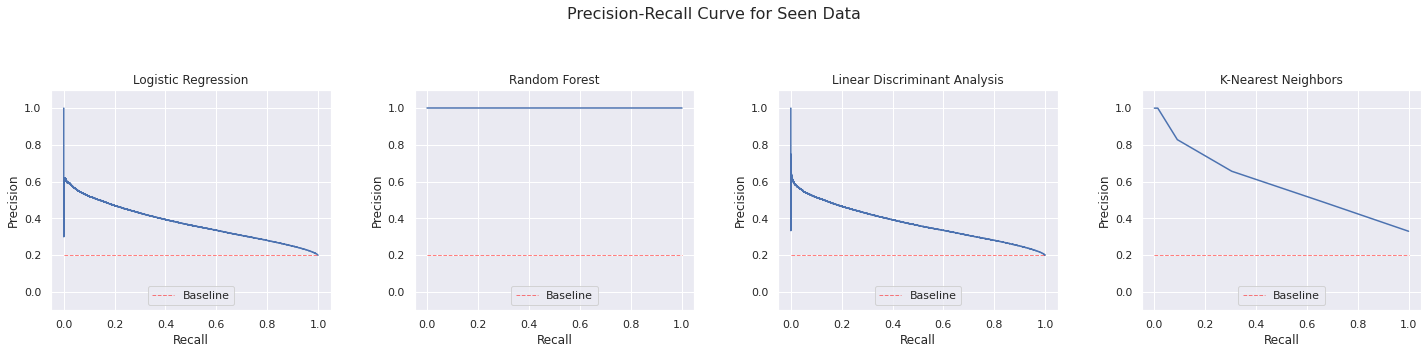

In [19]:
plot_pr_curves(loan_data_train_labels, target_scores_seen, 
               pos_label='Charged Off', descr='Seen Data')

We observe that the Random Forest model has a perfect score, which is to be 
expected because by default the nodes in each tree are expanded until all 
leaves are pure or until all leaves contain less than min_samples_split 
samples (2 by default). Essentially, the model is memorizing the training
data.

Let's print the Precision-Recall AUC for each model for seen data :

In [20]:
scores_pr_seen = print_pr_auc(loan_data_train_labels, target_scores_seen, 
                              pos_label='Charged Off', descr='Seen Data')

Precision-Recall AUC for Seen Data
----------------------------------
Logistic Regression: 0.37531
Random Forest: 1.0
Linear Discriminant Analysis: 0.3736
K-Nearest Neighbors: 0.50454


Let's plot the ROC curves for the decision value or probability predictions 
generated by each model for the training dataset (seen data):

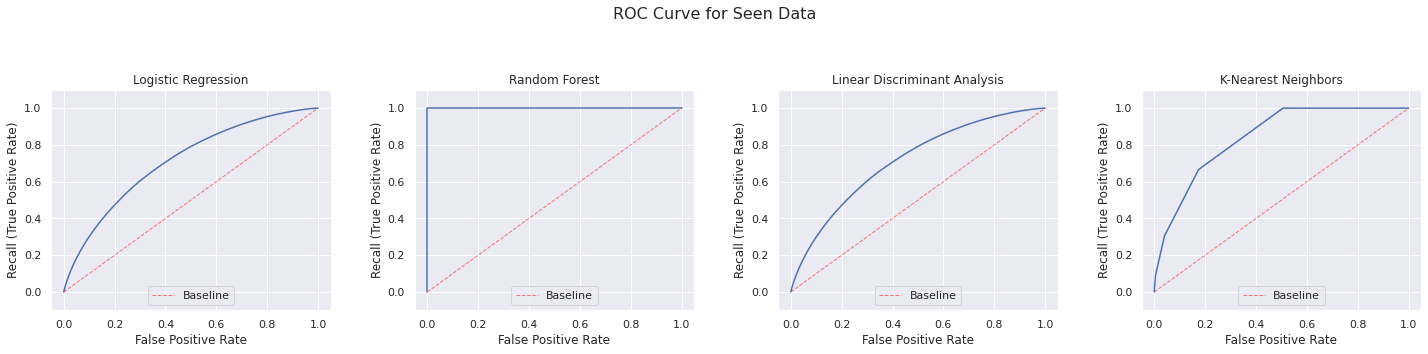

In [21]:
plot_roc_curves(loan_data_train_labels, target_scores_seen, 
                pos_label='Charged Off', descr='Seen Data')

Let's print the ROC AUC for each model for seen data:

In [22]:
scores_roc_seen = print_roc_auc(loan_data_train_labels, target_scores_seen, 
                                pos_label='Charged Off', descr='Seen Data')

ROC AUC for Seen Data
---------------------
Logistic Regression: 0.71218
Random Forest: 1.0
Linear Discriminant Analysis: 0.71213
K-Nearest Neighbors: 0.84281


We gather data needed to determine the cross-validated performance of the 
models on the the training dataset (unseen data):

In [23]:
%%time
# Generate cross-validated decision value or probability of 'Charge Off' for 
# each instance in the training dataset for each model. Store the values in 
# a dictionary with model names as keys, and arrays as values.
print('Progress Report')
print('---------------')
target_scores_unseen = {}
for key in models:
    if hasattr(models[key], 'decision_function'):
        # The function 'decision_function' returns the values of the class 
        # with the greater label, which in our case is 'Fully Paid', so we 
        # negate the values.
        target_scores_unseen[key] = -cross_val_predict(
            models[key], loan_data_train, loan_data_train_labels, cv=5, 
            method='decision_function', n_jobs=-1, verbose=10)
    else:
        target_scores_unseen[key] = cross_val_predict(
            models[key], loan_data_train, loan_data_train_labels, cv=5, 
            method='predict_proba', n_jobs=-1, verbose=10)[:, 0]
    print(f'{key}: Done')
sleep(2)

Progress Report
---------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 91.2min remaining: 136.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 91.3min remaining: 60.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 91.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 91.5min finished


Logistic Regression: Done


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 90.0min remaining: 135.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 90.1min remaining: 60.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 91.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 91.0min finished


Random Forest: Done


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 79.5min remaining: 119.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 84.8min remaining: 56.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 85.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 85.3min finished


Linear Discriminant Analysis: Done


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 88.5min remaining: 132.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 89.1min remaining: 59.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 89.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 89.8min finished


K-Nearest Neighbors: Done
CPU times: user 12.4 s, sys: 7.68 s, total: 20.1 s
Wall time: 5h 57min 41s


Let's plot the Precision-Recall curves for the cross-validated decision value 
or probability predictions generated by each model for the training dataset 
(unseen data):

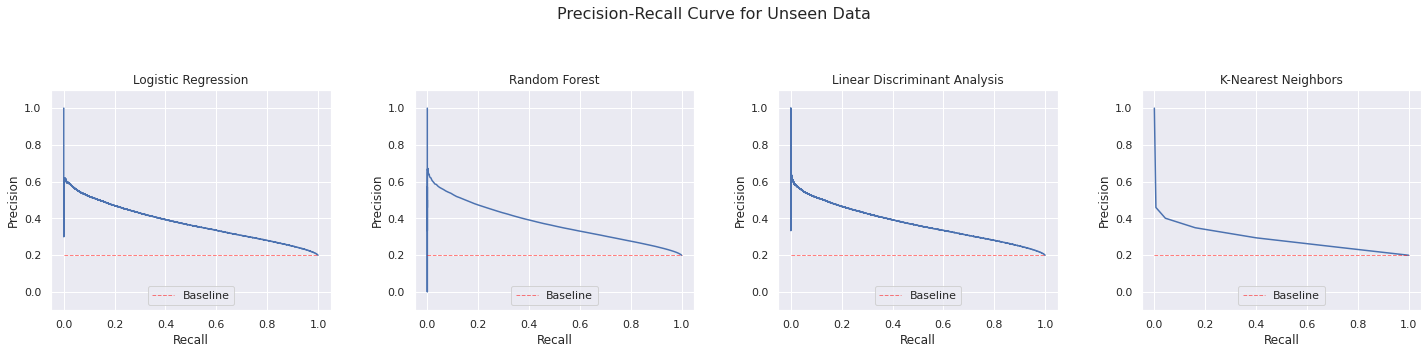

In [24]:
plot_pr_curves(loan_data_train_labels, target_scores_unseen, 
               pos_label='Charged Off', descr='Unseen Data')

Let's print the Precision-Recall AUC for each model for unseen data:

In [25]:
scores_pr_unseen = print_pr_auc(loan_data_train_labels, target_scores_unseen, 
                                pos_label='Charged Off', descr='Unseen Data')

Precision-Recall AUC for Unseen Data
------------------------------------
Logistic Regression: 0.375
Random Forest: 0.37163
Linear Discriminant Analysis: 0.37332
K-Nearest Neighbors: 0.26292


Let's plot the ROC curves for the cross-validated decision value or 
probability predictions generated by each model for the training dataset 
(unseen data):

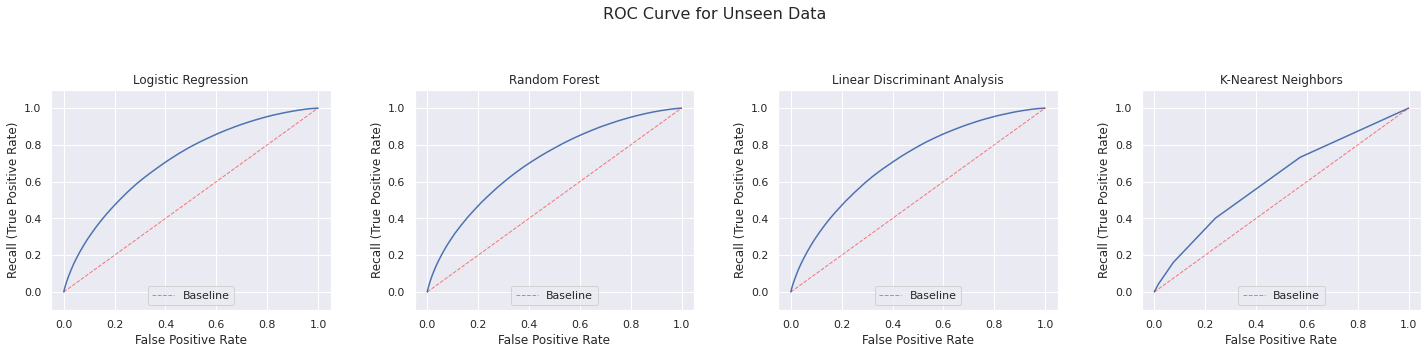

In [26]:
plot_roc_curves(loan_data_train_labels, target_scores_unseen, 
                pos_label='Charged Off', descr='Unseen Data')

Let's print the ROC AUC for each model for unseen data:

In [27]:
scores_roc_unseen = print_roc_auc(
    loan_data_train_labels, target_scores_unseen, pos_label='Charged Off', 
    descr='Unseen Data')

ROC AUC for Unseen Data
-----------------------
Logistic Regression: 0.71195
Random Forest: 0.7081
Linear Discriminant Analysis: 0.7119
K-Nearest Neighbors: 0.61126


Let's summarize the results obtained thus far:



In [28]:
# Gather the Precision-Recall scores into a dataframe.
df_pr = pd.DataFrame({
    'Seen': [scores_pr_seen[key] for key in clf_names],
    'Unseen': [scores_pr_unseen[key] for key in clf_names]
}, index=clf_names)

# Gather the ROC scores into a dataframe.
df_roc = pd.DataFrame({
    'Seen': [scores_roc_seen[key] for key in clf_names],
    'Unseen': [scores_roc_unseen[key] for key in clf_names]
}, index=clf_names)

# Concatenate the two dataframes.
df = pd.concat([df_pr, df_roc], axis=1, 
               keys=['Precision-Recall AUC', 'ROC AUC'])

# Round to five decimal places in pandas. 
pd.options.display.float_format = '{:.5f}'.format
df

Precision-Recall AUC         ROC AUC        
                                             Seen  Unseen    Seen  Unseen
Logistic Regression                       0.37531 0.37500 0.71218 0.71195
Random Forest                             1.00000 0.37163 1.00000 0.70810
Linear Discriminant Analysis              0.37360 0.37332 0.71213 0.71190
K-Nearest Neighbors                       0.50454 0.26292 0.84281 0.61126

Based on the information gathered above, we observe that:

* All models are overfitting the training data. This is particularly 
severe for the Random Forest and K-Nearest Neighbors models.


* The K-Nearest Neighbors model is performing poorly. In general, the 
baseline for ROC AUC is 0.5, and the baseline for Precision-Recall AUC
is equal to the proportion of the data that belongs to the positive class. 
In our case, the positive class proportion is approximately 0.2, and so
the Precision-Recall AUC baseline is 0.2. The performance of the 
K-Nearest Neighbors model in terms of the Presicion-Recall AUC metric
is barely above the baseline.


* The three best models in terms of both metrics are Logistic Regression,
Linear Discriminant Analysis, and Random Forest. There are no 
meaningful hyperparameters to tune for the Linear Discriminant Analysis 
model. We will tune the hyperparameter for the Logistic Regression and the
Random Forest model, with an aim to reduce overfitting. Since the two 
metrics seem to give identical rankings, we will restrict ourselves to the 
ROC AUC metric in what follows.

## 3. Tune Hyperparameters and Select the Best Model

We begin by tuning hyperparameters for the Logistic Regression model. 
The parameter grid below was arrived at after some experimentation, which 
is not shown in this notebook.

In [29]:
%%time
# Hyperparameter grid for logistic regression. Recall that C denotes the
# inverse of the regularization strength.
param_grid_logreg = [
    {'classifier__solver': ['saga'], 'classifier__penalty': ['l1', 'l2'], 
     'classifier__C': [1/2, 1/3, 1/4, 1/5]},
    {'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2'], 
     'classifier__C': [1/2, 1/3, 1/4, 1/5]}
]
grid_search_cv_logreg = GridSearchCV(logreg_clf, param_grid_logreg, cv=5, 
                                     scoring='roc_auc', refit=False,
                                     n_jobs=-1, verbose=10)
print('Progress Report')
print('---------------')
grid_search_cv_logreg.fit(loan_data_train, loan_data_train_labels)
sleep(2)

Progress Report
---------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 584.7min
[Parallel(n_jobs=-1)]: Done   3 out of  60 | elapsed: 586.1min remaining: 11135.8min
[Parallel(n_jobs=-1)]: Done  10 out of  60 | elapsed: 587.3min remaining: 2936.6min
[Parallel(n_jobs=-1)]: Done  17 out of  60 | elapsed: 588.0min remaining: 1487.3min
[Parallel(n_jobs=-1)]: Done  24 out of  60 | elapsed: 588.5min remaining: 882.8min
[Parallel(n_jobs=-1)]: Done  31 out of  60 | elapsed: 589.7min remaining: 551.6min
[Parallel(n_jobs=-1)]: Done  38 out of  60 | elapsed: 863.5min remaining: 499.9min
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed: 870.0min remaining: 290.0min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 930.3min remaining: 143.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 935.7min finished


CPU times: user 48.8 s, sys: 11.7 s, total: 1min
Wall time: 15h 35min 44s


Next, we tune hyperparameters for the Random Forest model:

In [30]:
%%time
# Hyperparameter grid for random forest.  The default for max_features is
# sqrt(n_features); in the present case, n_features = 106, and so 
# the default value of max_features is 10.
param_grid_rnd_forest = [
    {'classifier__max_depth': [6, 9, 12, 15],
     'classifier__max_features': [8, 9, 10, 11, 12]}
]

grid_search_cv_rnd_forest = GridSearchCV(
    rnd_forest_clf, param_grid_rnd_forest, cv=5, scoring='roc_auc', 
    refit=False, n_jobs=-1, verbose=10)
print('Progress Report')
print('---------------')
grid_search_cv_rnd_forest.fit(loan_data_train, loan_data_train_labels)
sleep(2)

Progress Report
---------------
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 585.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 588.8min
[Parallel(n_jobs=-1)]: Done  40 out of 100 | elapsed: 1129.9min remaining: 1694.8min
[Parallel(n_jobs=-1)]: Done  51 out of 100 | elapsed: 1144.0min remaining: 1099.1min
[Parallel(n_jobs=-1)]: Done  62 out of 100 | elapsed: 1149.8min remaining: 704.7min
[Parallel(n_jobs=-1)]: Done  73 out of 100 | elapsed: 1402.3min remaining: 518.6min
[Parallel(n_jobs=-1)]: Done  84 out of 100 | elapsed: 1513.1min remaining: 288.2min
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 1536.9min remaining: 80.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 1541.9min finished


CPU times: user 1min 32s, sys: 24.1 s, total: 1min 56s
Wall time: 1d 1h 41min 55s


Let's print the best cross-validated mean scores and best hyperparameters for 
our two models:

In [31]:
print('Logistic Regression')
print('-------------------')
print(f'Best Score: {round(grid_search_cv_logreg.best_score_, 5)}')
print('Best Hyperparameters:')
for key in grid_search_cv_logreg.best_params_:
    print(f'    {key[12:]}:', grid_search_cv_logreg.best_params_[key])
    
print('\n\nRandom Forest')
print('-------------')
print(f'Best Score: {round(grid_search_cv_rnd_forest.best_score_, 5)}')
print('Best Hyperparameters:')
for key in grid_search_cv_rnd_forest.best_params_:
    print(f'    {key[12:]}:', grid_search_cv_rnd_forest.best_params_[key])

Logistic Regression
-------------------
Best Score: 0.71195
Best Hyperparameters:
    C: 0.2
    penalty: l2
    solver: lbfgs


Random Forest
-------------
Best Score: 0.71555
Best Hyperparameters:
    max_depth: 15
    max_features: 12


Hyperparameter tuning did not help much. We choose the Logistic 
Regression model as our final model, even though the Random Forest model
has a slightly better score. The chosen model has the added advantage that 
it is naturally well-calibrated in terms of output probabilities, a 
beneficial feature given than our model will serve as the backend of a web 
app that predicts the probability that a given loan will be charged-off.

In [32]:
final_model = logreg_clf.set_params(**grid_search_cv_logreg.best_params_)

Let's train the final model on the full training dataset:

In [33]:
%%time
print('Progress Report')
print('---------------')
_ = final_model.fit(loan_data_train, loan_data_train_labels)

Progress Report
---------------
CPU times: user 1h 8min 12s, sys: 4.99 s, total: 1h 8min 17s
Wall time: 1h 6min 12s


In [34]:
# Read the test data into a pandas dataframe.
loan_data_test = pd.read_hdf('data/loan_data_train_and_test.hd5', key='test')

In [35]:
n_rows, n_cols = loan_data_test.shape
print(f'Size of the test dataset: {n_rows} rows and {n_cols} columns')

Size of the test dataset: 269062 rows and 28 columns


Let’s separate the predictor features and the target feature (labels):

In [36]:
loan_data_test_labels = loan_data_test['loan_status'].copy()
loan_data_test.drop(columns=['loan_status'], inplace=True)

Let's evaluate the final model on the test set:

In [37]:
# The function 'decision_function' returns the values of the class with the 
# greater label, which in our case is 'Fully Paid', so we negate the values.
target_scores_test = -final_model.decision_function(loan_data_test)
_ = print_roc_auc(loan_data_test_labels, 
                 {'Final Model (Logistic Regression)': target_scores_test}, 
                 pos_label='Charged Off', descr='Test Data')

ROC AUC for Test Data
---------------------
Final Model (Logistic Regression): 0.71159


In [38]:
# Concatenate the training and test datasets.
loan_data = pd.concat([loan_data_train, loan_data_test], axis=0)
loan_data_labels = pd.concat([loan_data_train_labels, loan_data_test_labels], 
                             axis=0)

n_rows, n_cols = loan_data.shape
print(f'Size of the full dataset: {n_rows} rows and {n_cols} columns')

Size of the full dataset: 1345306 rows and 27 columns


Before saving the final model, let's train it on the full dataset:

In [39]:
%%time
print('Progress Report')
print('---------------')
_ = final_model.fit(loan_data, loan_data_labels)

Progress Report
---------------
CPU times: user 1h 51min 43s, sys: 11.3 s, total: 1h 51min 54s
Wall time: 1h 49min 20s


In [40]:
# Save the final model.
dill.dump(final_model, open('final_model.pkl', 'wb'))